# ReesSaver Discriminator Agent

## Notes:
- Roughly 90% of our boards are unique
- Every time you call generate_data it gets new games/games in a different order?

In [1]:
import chess

import chess.svg
import cv2

from IPython.display import display, SVG

import numpy as np
import random
from tqdm import tqdm
from importlib import reload
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import utils
reload(utils)
import utils

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

C:\Users\osama\anaconda3\lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [2]:
if torch.cuda.is_available():
    # Set default tensor type to CUDA tensors
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    
else:
    
    torch.set_default_tensor_type(torch.FloatTensor)
 
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

made_loader = False

True


In [4]:
torch.cuda.empty_cache()
gc.collect()

0

In [5]:
def clear_cuda():
    
    input()
    
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            if obj.is_cuda:
                print(type(obj), obj.size(), obj.device)
                del obj
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
clear_cuda()

In [6]:
from utils.Datasets import *

import utils.Dataloading
reload(utils.Dataloading)
from utils.Dataloading import *
from utils.Game_playing import *

import utils.Playing_agents
reload(utils.Playing_agents)
from utils.Playing_agents import *

from utils.CSV_data import *
from utils.Puzzles import *

In [7]:
class MLPv2_1(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')

        self.layers = nn.ModuleList()

        self.depth = 6

        for _ in range(self.depth):
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))
            self.layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            self.layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):

        x = self.conv1(x)

        for i in range(self.depth):
            j = i*4
            ph = x.clone()
            ph = self.layers[j](ph)
            ph = self.layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.layers[j+2](ph)
            ph = self.layers[j+3](ph)

            x = x + ph
            x = F.relu(x)


        x = torch.flatten(x, start_dim=1)

        x = self.linear(x)

        minn, ila = x[:,:64], x[:,64:]

        return minn, ila

In [8]:
RDv2 = torch.load("Models/RDv2.3 CB.pt", map_location= device)

In [7]:
boards, meta, elo, moves, _, _, fens = generate_data("./Data/GAN_human_data.pgn", N = 30_000)

0it [00:00, ?it/s]
100%|██████████| 30000/30000 [10:17<00:00, 48.61it/s]


In [9]:
class generator_1(nn.Module):

    def __init__(self, conv_depth):

        super().__init__()
        self.conv1 = nn.Conv2d(14, 64, 3, 1, padding=1, padding_mode = 'zeros')
        
        self.conv_layers = nn.ModuleList()
        self.conv_depth = conv_depth
        
        for i in range(self.conv_depth):
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #self.conv_layers.append(nn.BatchNorm2d(64))
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #if i < self.conv_depth - 1:
                #self.conv_layers.append(nn.BatchNorm2d(64))

        self.linear = nn.Linear(4096, 128)

    def forward(self, x):

        x = self.conv1(x)
        
        for i in range(self.conv_depth):
            j = i*2
            ph = x.clone()
            ph = self.conv_layers[j](ph)
            #ph = self.conv_layers[j+1](ph)
            ph = F.relu(ph)
            ph = self.conv_layers[j+1](ph)
            #if i < self.conv_depth - 1:
                #ph = self.conv_layers[j+3](ph)
            
            x = x + ph
            x = F.relu(x)   
        
        x = torch.flatten(x, start_dim=1)

        x = self.linear(x)
        minn, ila = x[:,:64], x[:,64:]

        minn = F.softmax(minn, dim=1)
        ila = F.softmax(ila, dim=1)

        return torch.cat([minn, ila], dim=1).view(-1, 2, 8, 8)

In [10]:
class discriminator_1(nn.Module):

    def __init__(self, conv_depth):

        super().__init__()
        self.conv1 = nn.Conv2d(16, 64, 3, 1, padding=1, padding_mode = 'zeros')

        self.conv_layers = nn.ModuleList()
        self.conv_depth = conv_depth

        for _ in range(self.conv_depth):
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #self.conv_layers.append(nn.BatchNorm2d(64))
            self.conv_layers.append(nn.Conv2d(64,64, 3, 1, padding=1, padding_mode = 'zeros'))
            #self.conv_layers.append(nn.BatchNorm2d(64))
            
        self.linear = nn.Linear(4096, 1)
    

    def forward(self, board, move):
        
        x = torch.cat((board, move), dim = 1)

        x = self.conv1(x)
        
        for i in range(self.conv_depth):
            j = i*2
            ph = x.clone()
            ph = self.conv_layers[j](ph)
            #ph = self.conv_layers[j+1](ph)
            ph = F.leaky_relu(ph)
            #ph = self.conv_layers[j+2](ph)
            ph = self.conv_layers[j+1](ph)
            
            x = x + ph
            x = F.leaky_relu(x)
                  
                  
        x = torch.flatten(x, start_dim=1)
        
        x = self.linear(x)
        x = F.sigmoid(x)
        
        return x

In [83]:
class GAN_1(nn.Module):
    #AI: 0, Human: 1
    def __init__(self, g_conv_depth, d_conv_depth, lr, pre_trained_g = None):
        
        super().__init__()
        
        print(device)
        
        self.save_every = 2
        
        if pre_trained_g is not None:
            
            self.generator = pre_trained_g
            self.pre_trained = True
        
        else:
            
            self.generator = generator_1(g_conv_depth)
            self.pre_trained = False


        self.discriminator = discriminator_1(d_conv_depth)
        
        self.logs = {"g_acc": [0], "d_acc_r": [0], "d_acc_f": [0], 
                     "g_loss": [0], "d_loss": [0],"d_dist_f": [0], "d_dist_r": [0], 
                     "cur_g_loss": 0, "cur_d_loss": 0}
        
        self.made_loader = False
        
        self.configure_optimizers(lr)
        self.categorical_loss_1 = torch.nn.CrossEntropyLoss()
        self.categorical_loss_2 = torch.nn.CrossEntropyLoss()
        
        
        
    def forward(self, x):
        return self.generator(x)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def stockfish_train(self, train_boards, moves):

        self.generator.train()
        
        self.opt_g.zero_grad()

        fake_moves = self(train_boards)

        moves = moves.view(-1, 128)

        if self.pre_trained:

            fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
            g_loss = self.categorical_loss_1(fake_moves[0], moves[:,:64]) + self.categorical_loss_2(fake_moves[1], moves[:,64:])
            
        else:
            
            fake_moves = fake_moves.view(-1, 128)

            g_loss = self.categorical_loss_1(fake_moves[:,:64], moves[:,:64]) + self.categorical_loss_2(fake_moves[:,64:], moves[:,64:])
            
        #g_loss = torch.sum(torch.log((y - y_hat) + epsilon), dim=0)

        self.logs["cur_g_loss"] += g_loss.item()

        g_loss.backward()

        self.opt_g.step()
    
    def train_step(self, train_boards, real_moves, train_generator, prev_generator=None):

        self.discriminator.train()

        self.generator.train()

        epsilon = 1e-8
        
        #train generator
        if train_generator:

            self.opt_g.zero_grad()
            
            fake_moves = self(train_boards)
            
            if self.pre_trained:
                
                fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8)
                
            else:
                
                fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8)
            
            y_hat = self.discriminator(train_boards, fake_moves)
            
            y = torch.zeros(real_moves.size(0), 1).to(device)
            
            g_loss = -1 * self.adversarial_loss(y_hat, y)
            #g_loss = torch.sum(torch.log((y - y_hat) + epsilon), dim=0)
                        
            self.logs["cur_g_loss"] += g_loss.item()
            
            g_loss.backward()

            self.opt_g.step()
              
        #discriminator training 
        else:

            self.opt_d.zero_grad()
            
            y_hat_real = self.discriminator(train_boards, real_moves)
            y_real = torch.ones(real_moves.size(0), 1).to(device)
            
            #d_real_loss = torch.sum(y_hat_real, dim = 0)
            d_real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            if prev_generator is not None:
                
                prev_fake_moves = prev_generator(train_boards[:len(train_boards)//8])
                fake_moves = self(train_boards[len(train_boards)//8:])

                if self.pre_trained:

                    fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                    fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()
                    prev_fake_moves = F.softmax(prev_fake_moves[0], dim=1), F.softmax(prev_fake_moves[1], dim=1)
                    prev_fake_moves = self.diffable_argmax_moves((torch.cat(prev_fake_moves,dim=1))).view(-1,2,8,8).detach()

                else:

                    fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8).detach()
                    prev_fake_moves = self.diffable_argmax_moves(prev_fake_moves).view(-1,2,8,8).detach()
                
                fake_moves = torch.cat([prev_fake_moves, fake_moves], dim=0)

                
            else:
                
                fake_moves = self(train_boards)

                if self.pre_trained:
                    fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
                    fake_moves = self.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()

                else:

                    fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8).detach()

            
            y_hat_fake = self.discriminator(train_boards, fake_moves)
            y_fake = torch.zeros(real_moves.size(0), 1).to(device)

            #d_fake_loss = torch.sum(y_hat_fake, dim = 0)
            d_fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            
            d_loss = d_fake_loss + d_real_loss # - d_fake_loss * d_real_loss
            self.logs["cur_d_loss"] += d_loss.item()
            
            d_loss.backward()

            self.opt_d.step()
            
            #for param in self.discriminator.parameters():
            #    param.data.clamp_(-0.01, 0.01)
            
    def diffable_argmax_moves(self, moves):
        
        moves = moves.view(-1,2,64)
        # Create a tensor to hold the transformed results
        transformed_tensor = torch.zeros_like(moves).to(device)
    
        # Find the indices of the maximum values along the last two dimensions
        max_indices = torch.argmax(moves, dim=2, keepdim=True).to(device) # 5000, 2
    
        # Create a mask where the maximum indices are set to 1
        idx0 = torch.arange(transformed_tensor.size(0)).unsqueeze(1).unsqueeze(2).to(device)
        idx1 = torch.arange(transformed_tensor.size(1)).unsqueeze(0).unsqueeze(2).to(device)
    
        transformed_tensor[idx0, idx1, max_indices] = 1
        
        moves = moves * transformed_tensor

        moves /= moves[idx0, idx1, max_indices]
    
        return moves
            
    
    def configure_optimizers(self, lr):
        self.lr = lr
        self.opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas = (0.5, 0.999),  weight_decay=0.0)
        self.opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr,  betas = (0.5, 0.999), weight_decay=0.0)
    
    def on_epoch_end(self, epoch, G, val_data=None):
        
        self.logs["g_loss"].append(self.logs["cur_g_loss"] / G)
        self.logs["d_loss"].append(self.logs["cur_d_loss"] / G)
        
        print(f'Epoch {epoch+1} with g_loss: {self.logs["cur_g_loss"] / G} and d_loss: {self.logs["cur_d_loss"] / G}')
        
        self.logs["cur_g_loss"] = 0
        self.logs["cur_d_loss"] = 0
        
        if epoch % 1 == 0:
            
            if val_data is not None:
                
                self.discriminator.eval()
                
                self.generator.eval()
                
                val_boards = val_data.bitboards
                real_moves = val_data.moves
                
                #fake_moves_ind = torch.argmax(fake_moves, dim=1)
                values = np.zeros(5)
                
                for i in range(0,len(val_boards), 100):
                
                    with torch.no_grad():
                        
                        curr_boards, curr_moves = val_boards[i:i+100], real_moves[i:i+100]
    
                        fake_moves = self(curr_boards)
                                                
                        if self.pre_trained:
                            
                            fake_from_moves = torch.argmax(fake_moves[0], dim=1)
                            fake_to_moves = torch.argmax(fake_moves[1], dim=1)
                            real_from_moves = torch.argmax(curr_moves[:,0].view(-1,64), dim=1)
                            real_to_moves = torch.argmax(curr_moves[:,1].view(-1,64), dim=1)
                            values[4] += torch.sum((fake_from_moves == real_from_moves) & (fake_to_moves == real_to_moves)).item()/fake_from_moves.size(0)
                        
                            fake_moves = self.diffable_argmax_moves(torch.cat([F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)], dim=1)).view(-1,2,8,8)

                        else:

                            fake_moves = self.diffable_argmax_moves(fake_moves).view(-1,2,8,8)


                        f_pred = self.discriminator(curr_boards, fake_moves)
                        r_pred = self.discriminator(curr_boards, curr_moves)
    
                        values[0] += torch.mean(torch.round(f_pred) == 0, dtype=torch.float).item() #d_acc_f
                        values[1] += torch.mean(torch.round(r_pred) == 1, dtype=torch.float).item() #d_acc_r
    
                        values[2] += torch.mean(torch.abs(f_pred)) #d_dist_f
                        values[3] += torch.mean(torch.abs(1 - r_pred)) #d_dist_r

                        if not self.pre_trained:
    
                            values[4] += torch.mean((curr_moves.view(-1,128) == torch.round(fake_moves).view(-1,128)).all(dim=1), dtype=torch.float).item() # g_acc
                                                    
                n = int(len(val_boards) // 100)
                d_acc_f, d_acc_r = values[0] / n, values[1] / n
                d_dist_f, d_dist_r = values[2] / n, values[3] / n
                g_acc = values[4] / n
                
                print(f'Epoch: {epoch+1}, {g_acc=}, {d_acc_f=}, {d_acc_r=}')
                print(f"{d_dist_f=}, {d_dist_r=}")
                
                self.logs["d_acc_f"].append(d_acc_f)
                self.logs["d_acc_r"].append(d_acc_r)
                self.logs["d_dist_f"].append(d_dist_f)
                self.logs["d_dist_r"].append(d_dist_r)
                self.logs["g_acc"].append(g_acc)
                
                
            if epoch % self.save_every == 0:
            
                torch.save(self.generator, f"generator {epoch}.pt")
                torch.save(self.discriminator, f"discriminator {epoch}.pt")
            
    def create_dataloader(self, boards, meta, moves, B, N, N_val):

        if self.made_loader:

            clear_cuda()
            
        loader = DataLoader(GANData(boards[:N], meta[:N], moves[:N]), batch_size = B, shuffle = True, generator=torch.Generator(device=device))
        val_loader = GANData(boards[N:N+N_val], meta[N:N+N_val], moves[N:N+N_val])
        
        self.made_loader = True
        
        return loader, val_loader
        

        

In [12]:
class GANData(Dataset):

    def __init__(self, bitboards, white_turn, moves):

        self.bitboards = torch.tensor(bitboards, dtype = torch.float).to(device)

        self.moves = np.zeros((self.bitboards.size(dim=0), 128))

        for ind, move in tqdm(enumerate(moves), total=len(moves)):

            minn = move.from_square
            ila = move.to_square
        
            if not white_turn[ind]:
                minn = (63 - minn) // 8 * 8 + minn % 8
                ila = (63 - ila) // 8 * 8 + ila % 8

            self.moves[ind,minn] = 1
            self.moves[ind, ila + 64] = 1
            
            
        self.moves = torch.tensor(self.moves.reshape(-1,2,8,8), dtype = torch.float).to(device)

    def __len__(self):

        return self.moves.size(dim=0)


    def __getitem__(self, idx):

        return self.bitboards[idx], self.moves[idx]
    
    

In [126]:
for _ in range(4): clear_cuda()

<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 14, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 4096]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([128]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.Tensor'> torch.Size([64]) cuda:0
<class 'torch.Tensor'> torch.Size([]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cuda:0
<class 'torch.Tensor

In [77]:
del RSv1

In [30]:
del loader
del val_data

In [98]:
RSv1 = GAN_1(g_conv_depth=6, d_conv_depth=6, lr=0.0002, pre_trained_g=RDv2).to(device)

cuda


In [34]:
loader, val_data = RSv1.create_dataloader(boards, meta, moves, B = 128, N=len(boards)-4_001, N_val=4_000) # try B = 128
G = len(loader)

100%|██████████| 4000/4000 [00:00<00:00, 364856.93it/s]


In [97]:
torch.cuda.empty_cache()
gc.collect()

0

In [80]:
del RSv1.discriminator

RSv1.discriminator = discriminator_1(conv_depth=4)
RSv1.configure_optimizers(0.001)

In [35]:
del RSv1.generator

RSv1.generator = generator_1(conv_depth=6)
RSv1.configure_optimizers(0.0002)

In [100]:
train_discriminator = False
train_all = True
train_generator = False

In [101]:
r_bound, f_bound = 0.75,0.7
not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound)

True

In [ ]:
for epoch in range(0,50):

    reps = 0

    if train_all or train_discriminator:
        prev_generator = None

        if epoch > RSv1.save_every + 1 and not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            choice = np.random.choice(np.arange(start=RSv1.save_every, stop= (epoch//(RSv1.save_every+1) * RSv1.save_every)+1, step = RSv1.save_every))

            prev_generator = torch.load(f'generator {choice}.pt', map_location= device)
    
        while not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            
            reps += 1
            if reps > 20:
                train_all = False
                train_discriminator = False
                train_generator = False
                break

            i=0
            
            for bitboards, mvs in tqdm(loader):
                if i > G // 1:
                    break
                RSv1.train_step(bitboards, mvs, train_generator=False, prev_generator=prev_generator)
                i += 1

            print('Discriminator Training')
            RSv1.on_epoch_end(epoch, G, val_data)


    reps = 0
    if train_all or train_generator:
        
        while (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            reps += 1
            if reps > 20:
                train_all = False
                train_generator = False
                train_discriminator = False
                break

            i=0
            for bitboards, mvs in tqdm(loader):

                if i > G // 1:
                   break

                RSv1.train_step(bitboards, mvs, train_generator=True)
                i += 1
            
            print('Generator Training')
            RSv1.on_epoch_end(epoch, G, val_data)
            
        

In [ ]:
RSv1_generator = torch.load("generator 45.pt", map_location= device)
#old_discriminator = torch.load("discriminator 15.pt")

In [ ]:
test_against(old_generator_model, generator_model, N=200)

In [ ]:
generator_model(chess.Board())

In [45]:
old_generator_model = lambda x: network_agent_prob_conv(x, lambda y: RDv2(y))
generator_model = lambda x: network_agent_prob_conv(x, lambda y: (RSv1.generator(y)[:,:64], RSv1.generator(y)[:,64:]))

In [11]:
test_disc = torch.load("discriminator 15.pt", map_location=device)

In [28]:
fake_moves = test_gen(val_data.bitboards)

fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
fake_moves = torch.cat(fake_moves,dim=1).view(-1,2,8,8).detach()

torch.mean(test_disc(val_data.bitboards, fake_moves))

tensor(0.0005, grad_fn=<MeanBackward0>)

In [76]:
test_gen = torch.load("Models/RDv2.3 CB.pt", map_location=device)

In [21]:
fake_moves = RSv1(val_data.bitboards[:100])

fake_moves = F.softmax(fake_moves[0], dim=1), F.softmax(fake_moves[1], dim=1)
fake_moves = RSv1.diffable_argmax_moves(torch.cat(fake_moves,dim=1)).view(-1,2,8,8).detach()
print(fake_moves[0])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])


In [61]:
RSv1.discriminator(val_data.bitboards[0:1], fake_moves[0:1])

TypeError: eval() takes 1 positional argument but 2 were given

In [115]:
new_val = torch.round(fake_moves[0:1])

In [49]:
counter = 13

In [50]:
torch.all(val_data.moves[counter] == fake_moves[counter])

tensor(False)

In [58]:
val_data.bitboards[0:1].shape

torch.Size([1, 14, 8, 8])

In [62]:
RSv1.discriminator.eval()
RSv1.discriminator(val_data.bitboards[counter:counter+3], val_data.moves[counter:counter+3])

tensor([[3.5519e-03],
        [1.9832e-03],
        [5.9222e-08]], grad_fn=<SigmoidBackward0>)

In [63]:
RSv1.discriminator(val_data.bitboards[counter:counter+1], fake_moves[counter:counter+1])

tensor([[0.0024]], grad_fn=<SigmoidBackward0>)

# Stockfish GAN

In [13]:
def load_stockfish_data(N=2_000_000):
    
    file_path = "Data/StockData.csv"
    epsilon = 1e-5
    
    df = pd.read_csv(file_path, nrows=N)
    ind_map = index_map.cpu().numpy()
    
    
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace=True)

    
    fens = np.array(df['FENs'])
    moves = np.zeros((len(fens), 128))
    h_moves = np.zeros((len(fens), 128))

    bitboards, meta = zip(*[fen_to_board(x) for x in tqdm(fens, total=len(fens))])
    
    bitboards = np.asarray(bitboards)

    meta = np.asarray(meta)
    
    for i in tqdm(range(4)):
        
        moves[df.index,df[f'move{i}'].apply(lambda x: chess.Move.from_uci(x).from_square)] += df[f'eval{i}'] + epsilon
        moves[df.index, 64 + df[f'move{i}'].apply(lambda x: chess.Move.from_uci(x).to_square)] += df[f'eval{i}'] + epsilon
        
    
    h_moves[df.index, df["hmoves"].apply(lambda x: chess.Move.from_uci(x).from_square)] = 1
    h_moves[df.index, 64 + df["hmoves"].apply(lambda x: chess.Move.from_uci(x).to_square)] = 1
    
    flipped_moves = np.zeros_like(moves)    
    flipped_moves[:,:64] = moves[:,ind_map]
    flipped_moves[:,64:] = moves[:,64+ind_map]
    #v_fens = np.vectorize(fen_to_board)
    moves = np.where(np.expand_dims(meta, 1), moves, flipped_moves)

    flipped_moves = np.zeros_like(h_moves)
    flipped_moves[:,:64] = h_moves[:,ind_map]
    flipped_moves[:,64:] = h_moves[:,64+ind_map]
    #v_fens = np.vectorize(fen_to_board)
    h_moves = np.where(np.expand_dims(meta, 1), h_moves, flipped_moves)
    
    #bitboards = np.array(list(map(fen_to_board, fens)))
    
    del df
    
    
    return bitboards, meta, h_moves, moves

In [14]:
print('Kernel saved')

Kernel saved


In [15]:
boards, meta, human_moves, stock_moves = load_stockfish_data(1_000_000)

100%|██████████| 4/4 [00:14<00:00,  3.60s/it]


In [16]:
num_samples = 5000
RDv2.eval()
ai_moves = RDv2(torch.tensor(boards[:num_samples], dtype=torch.float))

In [19]:
ai_moves = RSv1.diffable_argmax_moves(torch.cat([ai_moves[0], ai_moves[1]], dim = 1)).view(-1,128).detach().cpu()

In [21]:
stock_noise = np.random.uniform(low = 0, high = 1e-6, size = stock_moves.shape)
print(stock_noise[:5])

[[2.52466196e-07 3.04984963e-07 4.16688941e-07 3.60768491e-07
  7.77914074e-07 5.88311338e-08 5.75362964e-07 1.94478886e-07
  9.23971632e-07 5.73072450e-07 5.94121149e-07 9.31299174e-07
  1.32921466e-09 1.53425135e-07 8.64594282e-07 1.30694337e-07
  6.85967250e-07 9.28569655e-07 5.00052113e-07 7.65799226e-08
  5.83930833e-08 2.87230787e-07 3.05608406e-07 8.03506090e-07
  4.94408115e-08 7.20357389e-07 2.59115127e-07 2.23142638e-07
  5.40635329e-07 1.01392806e-07 8.01977084e-07 5.15490531e-07
  1.73186423e-07 4.44820399e-07 5.63938620e-07 9.83331731e-07
  5.35797613e-07 1.32722097e-07 8.73467479e-07 1.37637974e-07
  5.71536096e-07 3.72883939e-07 4.31668001e-07 1.26201868e-07
  9.85908226e-07 2.37145930e-07 5.15374749e-07 8.75569062e-08
  9.52941662e-07 4.36240717e-08 8.83694907e-07 8.37509844e-08
  7.06315095e-07 6.69401948e-07 8.90190017e-07 7.16245304e-07
  1.33435700e-07 2.68869233e-07 4.80818050e-07 6.46085627e-07
  7.31623261e-07 6.58971627e-07 1.27270595e-07 2.67421745e-07
  9.5993

In [22]:
stock_maxmoves = np.zeros_like(stock_moves)
stock_maxmoves[np.arange(len(stock_moves)), np.argmax(stock_moves[:,:64] + stock_noise[:,:64], axis = 1)] = 1
stock_maxmoves[np.arange(len(stock_moves)), 64 + np.argmax(stock_moves[:,64:] + stock_noise[:,64:], axis = 1)] = 1

In [23]:
df = pd.DataFrame({"Axis Number" : list(range(128))})

df['AI mean'] = torch.mean(ai_moves, axis=0)
df['AI std'] = torch.std(ai_moves, axis=0)

df['Human mean'] =  np.mean(human_moves, axis= 0)
df['Human std'] = np.std(human_moves, axis= 0)
df['Stock mean'] = np.mean(stock_maxmoves, axis= 0)
df['Stock std'] = np.std(stock_maxmoves, axis= 0)

df['Distance'] = np.abs((df['AI mean'] - df['Human mean'])/df['Human mean'])
df.sort_values(['Distance'], inplace= True)
print(df.drop('Axis Number', axis = 1))

     AI mean    AI std  Human mean  Human std  Stock mean  Stock std  Distance
21    0.0452  0.207763    0.045206   0.207757    0.048017   0.213803  0.000141
9     0.0264  0.160338    0.026392   0.160297    0.024467   0.154494  0.000314
82    0.0352  0.184303    0.035182   0.184240    0.034034   0.181316  0.000503
1     0.0270  0.162100    0.027148   0.162514    0.028446   0.166245  0.005450
46    0.0048  0.069122    0.004769   0.068895    0.004680   0.068251  0.006454
..       ...       ...         ...        ...         ...        ...       ...
72    0.0020  0.044681    0.003755   0.061163    0.004242   0.064990  0.467371
121   0.0014  0.037394    0.003061   0.055238    0.002893   0.053707  0.542575
127   0.0014  0.037394    0.003083   0.055436    0.002473   0.049670  0.545843
57    0.0030  0.054696    0.001863   0.043120    0.002058   0.045317  0.610481
126   0.0004  0.019998    0.002424   0.049174    0.002248   0.047357  0.834980

[128 rows x 7 columns]


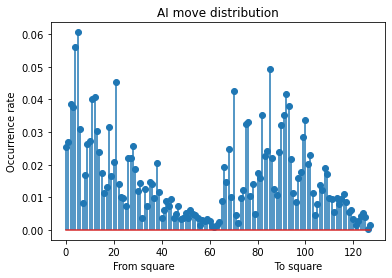

In [43]:
plt.stem(df.index, df['AI mean'])
plt.ylabel("Occurrence rate")
plt.xlabel("From square                                To square")
plt.title("AI move distribution")
plt.savefig("Results/AI_mean.png")

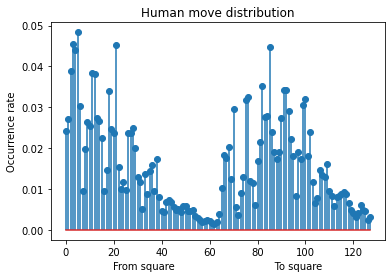

In [44]:
plt.stem(df.index, df['Human mean'])
plt.ylabel("Occurrence rate")
plt.xlabel("From square                                To square")
plt.title("Human move distribution")
plt.savefig("Results/Human_mean.png")

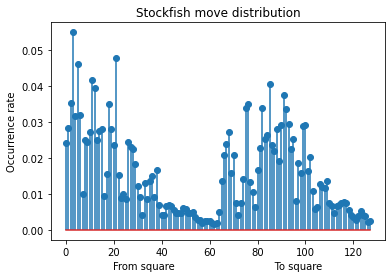

In [45]:
plt.stem(df.index, df['Stock mean'])
plt.ylabel("Occurrence rate")
plt.xlabel("From square                                To square")
plt.title("Stockfish move distribution")
plt.savefig("Results/stock_mean.png")

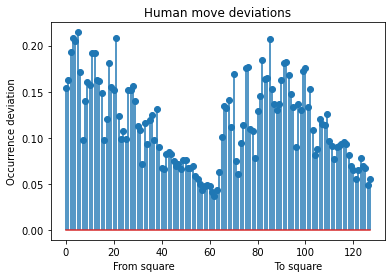

In [47]:
plt.stem(df.index, df["Human std"])
plt.ylabel("Occurrence deviation")
plt.xlabel("From square                                To square")
plt.title("Human move deviations")
plt.savefig("Results/human_std.png")

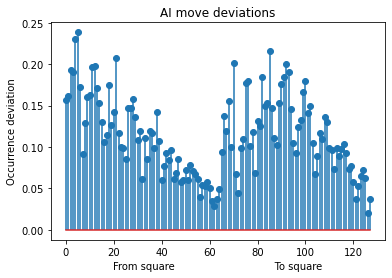

In [48]:
plt.stem(df.index, df["AI std"])
plt.ylabel("Occurrence deviation")
plt.xlabel("From square                                To square")
plt.title("AI move deviations")
plt.savefig("Results/AI_std.png")

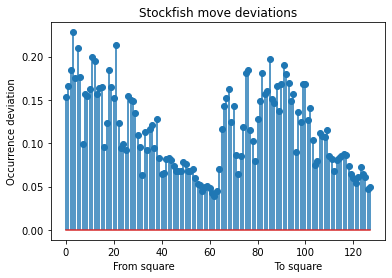

In [49]:
plt.stem(df.index, df["Stock std"])
plt.ylabel("Occurrence deviation")
plt.xlabel("From square                                To square")
plt.title("Stockfish move deviations")
plt.savefig("Results/stock_std.png")

In [50]:
class StockData(Dataset):

    def __init__(self, bitboards, moves, stock_moves):

        self.bitboards = torch.tensor(bitboards, dtype = torch.float).to(device)

        self.moves = torch.tensor(moves, dtype = torch.float).to(device)
        self.stock_moves = torch.tensor(stock_moves, dtype=torch.float).to(device)

    def __len__(self):

        return self.moves.size(dim=0)


    def __getitem__(self, idx):

        return self.bitboards[idx], self.moves[idx], self.stock_moves[idx]
    

In [112]:
del RSv1

In [113]:
RSv1 = GAN_1(g_conv_depth=6, d_conv_depth=6, lr=0.0002, pre_trained_g=None).to(device)

cuda


In [52]:
val_size = 2_000
B = 128
loader = DataLoader(StockData(boards[:-val_size], human_moves[:-val_size], stock_moves[:-val_size]), batch_size = B, shuffle = True, generator=torch.Generator(device=device))
val_data = StockData(boards[-val_size:], human_moves[-val_size:], stock_moves[-val_size:])
G = len(loader)

In [114]:
loader.dataset.stock_moves = torch.tensor(stock_maxmoves, dtype=torch.float).to(device)

In [116]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
del RSv1.discriminator

RSv1.discriminator = discriminator_1(conv_depth=4)
RSv1.configure_optimizers(0.001)

In [ ]:
del RSv1.generator

RSv1.generator = generator_1(conv_depth=6)
RSv1.configure_optimizers(0.0002)

In [117]:
train_discriminator = False
train_all = True
train_generator = False

r_bound, f_bound = 0.7, 0.7

In [118]:
for epoch in range(50):

    reps = 0

    if train_all or train_discriminator:
        prev_generator = None

        if epoch > RSv1.save_every + 1 and not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            choice = np.random.choice(np.arange(start=RSv1.save_every, stop= (epoch//(RSv1.save_every+1) * RSv1.save_every)+1, step = RSv1.save_every))

            prev_generator = torch.load(f'generator {choice}.pt', map_location= device)

        while not (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):

            reps += 1
            if reps > 20:
                train_all = False
                train_discriminator = False
                train_generator = False
                break

            i=0

            for bitboards, mvs, _ in tqdm(loader):
                if i > G // 3:
                    break
                RSv1.train_step(bitboards, mvs, train_generator=False, prev_generator=prev_generator)
                i += 1

            print('Discriminator Training')
            RSv1.on_epoch_end(epoch, G, val_data)


    reps = 0
    if train_all or train_generator:

        while (RSv1.logs['d_acc_f'][-1] > f_bound and RSv1.logs['d_acc_r'][-1] > r_bound):
            reps += 1
            if reps > 20:
                train_all = False
                train_generator = False
                train_discriminator = False
                break

            i=0
            for bitboards, mvs, stk_mvs in tqdm(loader):
                if i > G // 4:
                    break

                #RSv1.train_step(bitboards, mvs, train_generator=True)
                RSv1.stockfish_train(bitboards, stk_mvs)
                i += 1

            print('Generator Training')
            RSv1.on_epoch_end(epoch, G, val_data)
            
        

 33%|███▎      | 2478/7433 [01:12<02:25, 33.95it/s]


Discriminator Training
Epoch 1 with g_loss: 0.0 and d_loss: 0.04074382378455248
Epoch: 1, g_acc=0.0004999999888241291, d_acc_f=0.9914999753236771, d_acc_r=0.9904999762773514
d_dist_f=0.018376801908016206, d_dist_r=0.0175808385014534


 25%|██▌       | 1859/7433 [00:32<01:36, 57.60it/s]


Generator Training
Epoch 1 with g_loss: 2.010629179338804 and d_loss: 0.0
Epoch: 1, g_acc=0.05099999848753214, d_acc_f=0.0054999998770654205, d_acc_r=0.9904999762773514
d_dist_f=0.989339542388916, d_dist_r=0.0175808385014534


 33%|███▎      | 2478/7433 [01:13<02:26, 33.93it/s]


Discriminator Training
Epoch 2 with g_loss: 0.0 and d_loss: 0.19092432271900175
Epoch: 2, g_acc=0.05099999848753214, d_acc_f=0.9369999825954437, d_acc_r=0.8639999777078629
d_dist_f=0.1448886752128601, d_dist_r=0.14384400844573975


 25%|██▌       | 1859/7433 [00:32<01:36, 57.65it/s]


Generator Training
Epoch 2 with g_loss: 1.9686859987408512 and d_loss: 0.0
Epoch: 2, g_acc=0.06949999844655394, d_acc_f=0.6174999803304673, d_acc_r=0.8639999777078629
d_dist_f=0.4252596855163574, d_dist_r=0.14384400844573975


 33%|███▎      | 2478/7433 [01:13<02:26, 33.82it/s]


Discriminator Training
Epoch 3 with g_loss: 0.0 and d_loss: 0.2006436064588772
Epoch: 3, g_acc=0.06949999844655394, d_acc_f=0.9564999878406525, d_acc_r=0.7914999783039093
d_dist_f=0.12575372457504272, d_dist_r=0.20443305969238282


 25%|██▌       | 1859/7433 [00:31<01:35, 58.14it/s]


Generator Training
Epoch 3 with g_loss: 1.959290880831674 and d_loss: 0.0
Epoch: 3, g_acc=0.09199999682605267, d_acc_f=0.7429999828338623, d_acc_r=0.7914999783039093
d_dist_f=0.32365951538085935, d_dist_r=0.20443305969238282


 25%|██▌       | 1859/7433 [00:32<01:37, 57.37it/s]


Generator Training
Epoch 3 with g_loss: 1.9524595291925988 and d_loss: 0.0
Epoch: 3, g_acc=0.09799999669194222, d_acc_f=0.6719999819993973, d_acc_r=0.7914999783039093
d_dist_f=0.38543679714202883, d_dist_r=0.20443305969238282


 33%|███▎      | 2478/7433 [01:12<02:25, 34.03it/s]


Discriminator Training
Epoch 4 with g_loss: 0.0 and d_loss: 0.23202741043846395
Epoch: 4, g_acc=0.09799999669194222, d_acc_f=0.8919999867677688, d_acc_r=0.7989999800920486
d_dist_f=0.20346217155456542, d_dist_r=0.21735405921936035


 25%|██▌       | 1859/7433 [00:31<01:35, 58.13it/s]


Generator Training
Epoch 4 with g_loss: 1.9478081473909026 and d_loss: 0.0
Epoch: 4, g_acc=0.11549999564886093, d_acc_f=0.6949999809265137, d_acc_r=0.7989999800920486
d_dist_f=0.3577850103378296, d_dist_r=0.21735405921936035


 33%|███▎      | 2478/7433 [01:24<02:47, 29.50it/s]


Discriminator Training
Epoch 5 with g_loss: 0.0 and d_loss: 0.23516589735937715
Epoch: 5, g_acc=0.11549999564886093, d_acc_f=0.9019999831914902, d_acc_r=0.7854999870061874
d_dist_f=0.22725753784179686, d_dist_r=0.2244199514389038


 25%|██▌       | 1859/7433 [00:32<01:36, 57.50it/s]


Generator Training
Epoch 5 with g_loss: 1.9435918980678895 and d_loss: 0.0
Epoch: 5, g_acc=0.1089999970048666, d_acc_f=0.7904999792575836, d_acc_r=0.7854999870061874
d_dist_f=0.2959998846054077, d_dist_r=0.2244199514389038


 25%|██▌       | 1859/7433 [00:31<01:35, 58.12it/s]


Generator Training
Epoch 5 with g_loss: 1.9413199167496644 and d_loss: 0.0
Epoch: 5, g_acc=0.11949999630451202, d_acc_f=0.7439999788999557, d_acc_r=0.7854999870061874
d_dist_f=0.3420499563217163, d_dist_r=0.2244199514389038


 25%|██▌       | 1859/7433 [00:32<01:36, 58.06it/s]


Generator Training
Epoch 5 with g_loss: 1.938863425240067 and d_loss: 0.0
Epoch: 5, g_acc=0.1324999962002039, d_acc_f=0.7094999879598618, d_acc_r=0.7854999870061874
d_dist_f=0.36562366485595704, d_dist_r=0.2244199514389038


 25%|██▌       | 1859/7433 [00:31<01:35, 58.29it/s]


Generator Training
Epoch 5 with g_loss: 1.9372855460645373 and d_loss: 0.0
Epoch: 5, g_acc=0.11699999701231718, d_acc_f=0.6794999822974205, d_acc_r=0.7854999870061874
d_dist_f=0.39376049041748046, d_dist_r=0.2244199514389038


 33%|███▎      | 2478/7433 [01:24<02:48, 29.43it/s]


Discriminator Training
Epoch 6 with g_loss: 0.0 and d_loss: 0.24460016075733707
Epoch: 6, g_acc=0.11699999701231718, d_acc_f=0.8744999885559082, d_acc_r=0.763999980688095
d_dist_f=0.2233513355255127, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:32<01:36, 57.84it/s]


Generator Training
Epoch 6 with g_loss: 1.9372358025122696 and d_loss: 0.0
Epoch: 6, g_acc=0.13049999717622995, d_acc_f=0.7699999868869781, d_acc_r=0.763999980688095
d_dist_f=0.2929150819778442, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:31<01:35, 58.23it/s]


Generator Training
Epoch 6 with g_loss: 1.9363609427127866 and d_loss: 0.0
Epoch: 6, g_acc=0.12099999748170376, d_acc_f=0.7724999815225602, d_acc_r=0.763999980688095
d_dist_f=0.29927194118499756, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:31<01:35, 58.25it/s]


Generator Training
Epoch 6 with g_loss: 1.9356695799620367 and d_loss: 0.0
Epoch: 6, g_acc=0.15199999660253524, d_acc_f=0.7229999810457229, d_acc_r=0.763999980688095
d_dist_f=0.3377669334411621, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:32<01:36, 57.81it/s]


Generator Training
Epoch 6 with g_loss: 1.9337815541719405 and d_loss: 0.0
Epoch: 6, g_acc=0.140999997779727, d_acc_f=0.7579999834299087, d_acc_r=0.763999980688095
d_dist_f=0.3111117839813232, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:31<01:35, 58.34it/s]


Generator Training
Epoch 6 with g_loss: 1.9335516537404969 and d_loss: 0.0
Epoch: 6, g_acc=0.13599999621510506, d_acc_f=0.7319999754428863, d_acc_r=0.763999980688095
d_dist_f=0.3222696781158447, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:31<01:35, 58.50it/s]


Generator Training
Epoch 6 with g_loss: 1.9326491577859748 and d_loss: 0.0
Epoch: 6, g_acc=0.13299999609589577, d_acc_f=0.7344999790191651, d_acc_r=0.763999980688095
d_dist_f=0.3240424394607544, d_dist_r=0.25383405685424804


 25%|██▌       | 1859/7433 [00:32<01:37, 57.41it/s]


Generator Training
Epoch 6 with g_loss: 1.9319103930722363 and d_loss: 0.0
Epoch: 6, g_acc=0.13049999587237834, d_acc_f=0.6684999912977219, d_acc_r=0.763999980688095
d_dist_f=0.37199769020080564, d_dist_r=0.25383405685424804


 33%|███▎      | 2478/7433 [01:23<02:47, 29.56it/s]


Discriminator Training
Epoch 7 with g_loss: 0.0 and d_loss: 0.2567925260411158
Epoch: 7, g_acc=0.13049999587237834, d_acc_f=0.888999980688095, d_acc_r=0.7549999803304672
d_dist_f=0.22563648223876953, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.27it/s]


Generator Training
Epoch 7 with g_loss: 1.9315434446505482 and d_loss: 0.0
Epoch: 7, g_acc=0.13499999642372132, d_acc_f=0.7994999766349793, d_acc_r=0.7549999803304672
d_dist_f=0.2735307693481445, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.17it/s]


Generator Training
Epoch 7 with g_loss: 1.9308250627526682 and d_loss: 0.0
Epoch: 7, g_acc=0.12699999772012233, d_acc_f=0.7979999780654907, d_acc_r=0.7549999803304672
d_dist_f=0.28873581886291505, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:35, 58.07it/s]


Generator Training
Epoch 7 with g_loss: 1.9305966230479958 and d_loss: 0.0
Epoch: 7, g_acc=0.13849999569356441, d_acc_f=0.7664999753236771, d_acc_r=0.7549999803304672
d_dist_f=0.3032143354415894, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.41it/s]


Generator Training
Epoch 7 with g_loss: 1.930221919238479 and d_loss: 0.0
Epoch: 7, g_acc=0.11949999667704106, d_acc_f=0.8059999823570252, d_acc_r=0.7549999803304672
d_dist_f=0.2760096788406372, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.80it/s]


Generator Training
Epoch 7 with g_loss: 1.9306966873224372 and d_loss: 0.0
Epoch: 7, g_acc=0.14349999502301217, d_acc_f=0.7714999824762344, d_acc_r=0.7549999803304672
d_dist_f=0.30000839233398435, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.27it/s]


Generator Training
Epoch 7 with g_loss: 1.929426861181404 and d_loss: 0.0
Epoch: 7, g_acc=0.12599999718368055, d_acc_f=0.7679999768733978, d_acc_r=0.7549999803304672
d_dist_f=0.29370508193969724, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.14it/s]


Generator Training
Epoch 7 with g_loss: 1.9298621115703114 and d_loss: 0.0
Epoch: 7, g_acc=0.14299999698996543, d_acc_f=0.768999981880188, d_acc_r=0.7549999803304672
d_dist_f=0.30579049587249757, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.87it/s]


Generator Training
Epoch 7 with g_loss: 1.928056371527951 and d_loss: 0.0
Epoch: 7, g_acc=0.13949999678879976, d_acc_f=0.7659999787807464, d_acc_r=0.7549999803304672
d_dist_f=0.3113466739654541, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.79it/s]


Generator Training
Epoch 7 with g_loss: 1.9280341137599035 and d_loss: 0.0
Epoch: 7, g_acc=0.12849999740719795, d_acc_f=0.7614999800920487, d_acc_r=0.7549999803304672
d_dist_f=0.3135910749435425, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.37it/s]


Generator Training
Epoch 7 with g_loss: 1.928459253764066 and d_loss: 0.0
Epoch: 7, g_acc=0.14149999767541885, d_acc_f=0.7314999848604202, d_acc_r=0.7549999803304672
d_dist_f=0.3274733781814575, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.98it/s]


Generator Training
Epoch 7 with g_loss: 1.9285994871907546 and d_loss: 0.0
Epoch: 7, g_acc=0.14049999620765447, d_acc_f=0.7529999822378158, d_acc_r=0.7549999803304672
d_dist_f=0.3240565299987793, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:35, 58.08it/s]


Generator Training
Epoch 7 with g_loss: 1.9283043863185398 and d_loss: 0.0
Epoch: 7, g_acc=0.15049999617040158, d_acc_f=0.7839999765157699, d_acc_r=0.7549999803304672
d_dist_f=0.30089874267578126, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.14it/s]


Generator Training
Epoch 7 with g_loss: 1.9280729688354188 and d_loss: 0.0
Epoch: 7, g_acc=0.13799999617040157, d_acc_f=0.7549999803304672, d_acc_r=0.7549999803304672
d_dist_f=0.31532509326934816, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.37it/s]


Generator Training
Epoch 7 with g_loss: 1.9282197861817072 and d_loss: 0.0
Epoch: 7, g_acc=0.14649999514222145, d_acc_f=0.7789999783039093, d_acc_r=0.7549999803304672
d_dist_f=0.2989945650100708, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.98it/s]


Generator Training
Epoch 7 with g_loss: 1.926897709901795 and d_loss: 0.0
Epoch: 7, g_acc=0.15599999614059926, d_acc_f=0.7454999774694443, d_acc_r=0.7549999803304672
d_dist_f=0.3309146881103516, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.99it/s]


Generator Training
Epoch 7 with g_loss: 1.9289659025786816 and d_loss: 0.0
Epoch: 7, g_acc=0.1539999969303608, d_acc_f=0.7599999815225601, d_acc_r=0.7549999803304672
d_dist_f=0.3198237895965576, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.40it/s]


Generator Training
Epoch 7 with g_loss: 1.9275135450595386 and d_loss: 0.0
Epoch: 7, g_acc=0.1359999965876341, d_acc_f=0.7604999899864197, d_acc_r=0.7549999803304672
d_dist_f=0.32318429946899413, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.31it/s]


Generator Training
Epoch 7 with g_loss: 1.927633880205692 and d_loss: 0.0
Epoch: 7, g_acc=0.12799999658018352, d_acc_f=0.7939999818801879, d_acc_r=0.7549999803304672
d_dist_f=0.29161431789398196, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:32<01:36, 57.84it/s]


Generator Training
Epoch 7 with g_loss: 1.9280403499790593 and d_loss: 0.0
Epoch: 7, g_acc=0.14799999594688415, d_acc_f=0.7279999792575836, d_acc_r=0.7549999803304672
d_dist_f=0.3379359245300293, d_dist_r=0.2712568283081055


 25%|██▌       | 1859/7433 [00:31<01:35, 58.34it/s]


Generator Training
Epoch 7 with g_loss: 1.9268375728647722 and d_loss: 0.0
Epoch: 7, g_acc=0.13399999663233758, d_acc_f=0.7324999809265137, d_acc_r=0.7549999803304672
d_dist_f=0.3288094997406006, d_dist_r=0.2712568283081055


In [90]:
pd.DataFrame.from_dict(RSv1.logs).to_csv('Results/StockGAN.csv', index = None)

In [61]:
loader.dataset.moves.resize_(len(loader.dataset), 2, 8, 8)
loader.dataset.stock_moves.resize_(len(loader.dataset), 2, 8, 8)
val_data.moves.resize_(len(val_data), 2, 8, 8)
val_data.stock_moves.resize_(len(val_data), 2, 8, 8)

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           5.1000e-04, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [96]:
np.mean(np.all(human_moves == stock_maxmoves, axis=1))

0.22461283504911345

In [119]:
old_generator_model = lambda x: network_agent_prob_conv(x, lambda y: RDv2(y))
generator_model = lambda x: network_agent_prob_conv(x, lambda y: (RSv1.generator(y).view(-1,128)))

In [120]:
test_against(generator_model, old_generator_model, N=100, unique=True)

100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


(1, 99, 0, 0.01)

In [101]:
backup_model = torch.load("Models/StockGAN/generator 10.pt")